<h1 style="text-align:center">Análise Exploratória de Dados de Notícias de Jornal Web</h1>

<div align="center"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Correio_Braziliense.svg/2560px-Correio_Braziliense.svg.png" width="500px" height="50px" alt="Logo Correio Braziliense"></img></div>

<p align='justify'>As notícias de jornal web são coletadas diariamente por webscraping a partir do site de notícias <a href="https://www.correiobraziliense.com.br/">Correio Braziliense</a>. É um jornal brasileiro com sede em Brasília - DF, fundado em 21 de abril de 1960 por Assis Chateaubriand, juntamente com a inauguração da cidade e da TV Brasília. O nome veio do histórico <a href="https://pt.wikipedia.org/wiki/Correio_Braziliense_(1808)">Correio Brasiliense ou Armazém Literário</a>, editado em Londres a partir de 1808 por Hipólito José da Costa <cite><a href="https://pt.wikipedia.org/wiki/Correio_Braziliense">[Wikipedia]</a></cite>.</p>

<p align='justify'>Como premissa para as análises e organização do projeto, é utilizada a metodologia <a href="https://www.datascience-pm.com/crisp-dm-2/">Cross Industry Standard Process for Data Mining (CRISP-DM)</a>.</p>

<h2 style="text-align:left">Entendimento do Negócio</h2>

<p align='justify'>O conjunto de dados em análise, refere-se a notícias diárias de um jornal de Brasília-DF chamado Correio Braziliense, onde por meio da técnica de webscraping, é coletado as notícias diárias desse jornal, uma tabela dispõe de informações das URL's das notícias, tema, e data da extração, a outra tabela dispõe de informações da notícias em si, data da publicação, autor, título e o texto da notícias.</p>

<h3 style="text-align:left">Dicionário de dados</h3>
<p align='justify'>A seguir é demonstrado os campos (colunas) e sua respectiva descrição a que se refere tal dado em cada tabela construída no banco de dados.</p>

<h4 style="text-align:left">TB_JORNAIS</h4>
<p align='justify'>Tabela com informações básicas do jornal.</p>
    
|Campo|Descrição|
|:----|:--------|
|ID_JORNAL|Identificador único do jornal|
|DESC_JORNAL|Nome do jornal|
|URL_JORNAL|URL principal do jornal|

<h4 style="text-align:left">TB_URL_NOTICIAS</h4>
<p align='justify'>Tabela com informações das URL's da notícias extraídas do jornal.</p>

|Campo|Descrição|
|:----|:--------|
|ID_NOTICIA|Identificador único da notícia|
|DATA_EXTRACAO|Data da extração da url da notícia|
|DESC_JORNAL|Nome do jornal|
|DESC_TEMA|Nome do tema da notícia|
|URL_NOTICIA|URL da notícia|
|FLAG_EXTRAIDA|Flag (True ou False) se já foi extraído o texto da notícia|

<h4 style="text-align:left">TB_TEXTO_NOTICIAS</h4>
<p align='justify'>Tabela com informações das notícias extraídas do jornal.</p>

|Campo|Descrição|
|:----|:--------|
|ID_NOTICIA|Identificador único da notícia|
|URL|URL da notícia|
|DATA_PUBLICACAO|Data e hora da publicação da notícia|
|AUTOR|Autor(es) da notícia|
|TITULO|Título (manchete) da notícia|
|TEXTO|Texto da notícia|

<h2 style="text-align:left">Entendimento dos Dados</h2>

<p align='justify'>Nesta etapa é realizada a exploração dos dados, com o objetivo de entender as características da base de dados e possíveis ajustes necessários a serem realizados antes da etapa de visualização.</p>

In [15]:
#!pip install wordcloud -q

In [153]:
# Importa Bibliotecas.
import os
import sys
from dotenv import load_dotenv
import time
import re
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# Apresenta os dados no notebook
%matplotlib inline

import seaborn as sns
# Estilo dos gráficos
sns.set_style("darkgrid")

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')

import psycopg2 
import sqlalchemy               
from sqlalchemy import create_engine
from sqlalchemy import text

load_dotenv()

# Parametros do Pandas, limitando a quantidade máxima e a largura das colunas.
pd.set_option('max_colwidth', 5000)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafhael.martins\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Credenciais banco
host=os.getenv('BD_POSTGRESQL_HOST')
port=os.getenv('BD_POSTGRESQL_PORT')
dbname=os.getenv('BD_POSTGRESQL_DBNAME')
user=os.getenv('BD_POSTGRESQL_USE')
password=os.getenv('BD_POSTGRESQL_PASSWORD')

In [18]:
#path = "C:/Users/Usuario/Documents/GitHub/monitoring-webscraping-newspaper/dados/"
path='C:/Users/GITHUB/monitoring-webscraping-newspaper/dados/'

<h3 style="text-align:left">TB_JORNAIS</h3>

In [19]:
# Consultando dados anteriores no BD.
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')
conn = engine.connect()

df_jornais = pd.read_sql(text('''select * from tb_jornais;'''), conn)

# Proporção dos dados em linhas e colunas
print(df_jornais.shape)

conn.close()

(1, 3)


In [20]:
# Verificando os metadados da base
df_jornais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID_JORNAL    1 non-null      int64 
 1   DESC_JORNAL  1 non-null      object
 2   URL_JORNAL   1 non-null      object
dtypes: int64(1), object(2)
memory usage: 152.0+ bytes


In [21]:
# Verificando os tipos de dados.
print("Tipos de dados e sua frequência\n{}".format(df_jornais.dtypes.value_counts()))

Tipos de dados e sua frequência
object    2
int64     1
dtype: int64


In [22]:
# Observando a abse de dados
df_jornais.head()

,ID_JORNAL,DESC_JORNAL,URL_JORNAL
0,1,Correio Braziliense,https://www.correiobraziliense.com.br/


In [23]:
# Verificação da existência de dados ausentes/faltantes
df_jornais.isnull().sum()

ID_JORNAL      0
DESC_JORNAL    0
URL_JORNAL     0
dtype: int64

In [24]:
# Verificando dados nulos por registro e retornando a maior quantidade.
df_jornais.isna().sum(axis=1).max()

0

<h3 style="text-align:left">TB_URL_NOTICIAS</h3>

In [25]:
# Consultando dados anteriores no BD.
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')
conn = engine.connect()

df_url = pd.read_sql(text('''select * from tb_url_noticias;'''), conn)

# Proporção dos dados em linhas e colunas
print(df_url.shape)

conn.close()

(19978, 6)


In [26]:
# Verificando os metadados da base
df_url.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19978 entries, 0 to 19977
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_NOTICIA     19978 non-null  int64 
 1   DATA_EXTRACAO  19978 non-null  object
 2   DESC_JORNAL    19978 non-null  object
 3   DESC_TEMA      19978 non-null  object
 4   URL_NOTICIA    19978 non-null  object
 5   FLAG_EXTRAIDA  19978 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 800.0+ KB


In [27]:
# Verificando os tipos de dados.
print("Tipos de dados e sua frequência\n{}".format(df_url.dtypes.value_counts()))

Tipos de dados e sua frequência
object    4
int64     1
bool      1
dtype: int64


In [28]:
# Observando a abse de dados
df_url.head()

,ID_NOTICIA,DATA_EXTRACAO,DESC_JORNAL,DESC_TEMA,URL_NOTICIA,FLAG_EXTRAIDA
0,3,2022-09-24,correiobraziliense,home,https://www.correiobraziliense.com.br/politica/2022/09/5039139-tse-identifica-rs-605-milhoes-em-doacoes-suspeitas.html,True
1,4,2022-09-24,correiobraziliense,home,https://www.correiobraziliense.com.br/cidades-df/2022/09/5039108-confira-a-agenda-dos-candidatos-ao-gdf-para-este-sabado.html,True
2,261,2022-10-05,correiobraziliense,opiniao,https://www.correiobraziliense.com.br//opiniao/2022/10/5041502-artigo-o-brasil-mudou.html,True
3,1639,2022-10-13,correiobraziliense,home,https://www.correiobraziliense.com.br/cbforum/testedopezinho.html,True
4,2156,2022-10-17,correiobraziliense,tecnologia,https://www.correiobraziliense.com.br/tecnologia/2022/10/5044373-ia-vence-os-obstaculos.html,True


In [29]:
# Verificação da existência de dados ausentes/faltantes
df_url.isnull().sum()

ID_NOTICIA       0
DATA_EXTRACAO    0
DESC_JORNAL      0
DESC_TEMA        0
URL_NOTICIA      0
FLAG_EXTRAIDA    0
dtype: int64

In [30]:
# Verificando dados nulos por registro e retornando a maior quantidade.
df_url.isna().sum(axis=1).max()

0

<h3 style="text-align:left">TB_TEXTO_NOTICIAS</h3>

In [31]:
# Consultando dados anteriores no BD.
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')
conn = engine.connect()

df_txt = pd.read_sql(text('''select * from tb_texto_noticias;'''), conn)
print(df_txt.shape)

conn.close()

(19827, 6)


In [32]:
# Verificando os metadados da base
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19827 entries, 0 to 19826
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID_NOTICIA       19827 non-null  int64 
 1   URL              19827 non-null  object
 2   DATA_PUBLICACAO  19520 non-null  object
 3   AUTOR            19827 non-null  object
 4   TITULO           19827 non-null  object
 5   TEXTO            19827 non-null  object
dtypes: int64(1), object(5)
memory usage: 929.5+ KB


In [33]:
# Verificando os tipos de dados.
print("Tipos de dados e sua frequência\n{}".format(df_txt.dtypes.value_counts()))

Tipos de dados e sua frequência
object    5
int64     1
dtype: int64


In [34]:
# Observando a abse de dados
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [35]:
# Verificação da existência de dados ausentes/faltantes
df_txt.isnull().sum()

ID_NOTICIA           0
URL                  0
DATA_PUBLICACAO    307
AUTOR                0
TITULO               0
TEXTO                0
dtype: int64

In [36]:
# Verificando dados nulos por registro e retornando a maior quantidade.
df_txt.isna().sum(axis=1).value_counts()

0    19520
1      307
dtype: int64

<h2 style="text-align:left">Preparação dos Dados</h2>
<p align='justify'>Nesta etapa é realizada a preparação dos dados, com o objetivo de ajustar as inconsistências encontradas durante a análise exploratória dos dados, permitindo que na etapa de visualização dos dados, os mesmos estejam de forma adequada a apresentação das informações.</p>

<h3 style="text-align:left">TB_URL_NOTICIAS</h3>

In [37]:
df_url["DATA_EXTRACAO"].value_counts()

2023-01-25    309
2022-10-05    304
2022-10-13    296
2022-10-10    295
2022-11-29    197
             ... 
2022-10-23     74
2023-03-26     71
2022-10-16     66
2022-10-29     64
2022-09-24     45
Name: DATA_EXTRACAO, Length: 152, dtype: int64

In [38]:
df_url.groupby(by="DATA_EXTRACAO")["ID_NOTICIA"].count().sort_values(ascending=False)

DATA_EXTRACAO
2023-01-25    309
2022-10-05    304
2022-10-13    296
2022-10-10    295
2022-11-29    197
             ... 
2022-10-23     74
2023-03-26     71
2022-10-16     66
2022-10-29     64
2022-09-24     45
Name: ID_NOTICIA, Length: 152, dtype: int64

In [39]:
df_url["DESC_TEMA"].value_counts()

home                  6445
diversao-e-arte       2041
cidades-df            1862
brasil                1820
mundo                 1726
politica              1638
esportes              1287
economia              1098
ciencia-e-saude        614
concursos              423
euestudante            385
opiniao                287
revista-do-correio     118
tecnologia              99
holofote                88
turismo                 45
comunidadeei             2
Name: DESC_TEMA, dtype: int64

In [40]:
df_url["FLAG_EXTRAIDA"].value_counts()

True     19827
False      151
Name: FLAG_EXTRAIDA, dtype: int64

In [41]:
df_url.groupby(by=["DATA_EXTRACAO", "DESC_TEMA"])["ID_NOTICIA"].count().sort_values(ascending=False)

DATA_EXTRACAO  DESC_TEMA         
2022-10-10     home                  96
2023-01-25     home                  85
2023-02-02     home                  67
2022-12-06     home                  66
2023-01-30     home                  66
                                     ..
2023-02-28     opiniao                1
2022-11-01     revista-do-correio     1
2023-02-27     opiniao                1
               euestudante            1
2023-04-12     revista-do-correio     1
Name: ID_NOTICIA, Length: 1769, dtype: int64

<h3 style="text-align:left">TB_TEXTO_NOTICIAS</h3>

In [42]:
df_txt.columns

Index(['ID_NOTICIA', 'URL', 'DATA_PUBLICACAO', 'AUTOR', 'TITULO', 'TEXTO'], dtype='object')

In [43]:
df_txt["DATA_PUBLICACAO"].value_counts()

2022-10-12-0306:00:00-10800    28
2023-03-19-0306:00:00-10800    25
2022-10-09-0306:00:00-10800    24
2022-11-27-0306:00:00-10800    23
2022-12-18-0306:00:00-10800    23
                               ..
2022-11-29-0318:41:00-10800     1
2022-11-29-0315:52:00-10800     1
2022-11-29-0316:52:00-10800     1
2022-11-29-0316:05:00-10800     1
2023-04-11-0312:20:00-10800     1
Name: DATA_PUBLICACAO, Length: 15724, dtype: int64

In [44]:
registro = 20
print(df_txt["DATA_PUBLICACAO"][registro], end="\n\n")

print(df_txt["DATA_PUBLICACAO"][registro][:4])
print(df_txt["DATA_PUBLICACAO"][registro][5:7])
print(df_txt["DATA_PUBLICACAO"][registro][8:10], end="\n\n")

print(df_txt["DATA_PUBLICACAO"][registro][13:15])
print(df_txt["DATA_PUBLICACAO"][registro][16:18])
print(df_txt["DATA_PUBLICACAO"][registro][19:21])

2022-10-03-0314:47:00-10800

2022
10
03

14
47
00


In [45]:
df_txt["DATA_PUBLICACAO_AUX"] = df_txt["DATA_PUBLICACAO"].apply(lambda x: None if pd.isnull(x) else f"{str(x)[:4]}-{str(x)[5:7]}-{str(x)[8:10]}")
df_txt["HORA_PUBLICACAO_AUX"] = df_txt["DATA_PUBLICACAO"].apply(lambda x: None if pd.isnull(x) else f"{str(x)[13:15]}:{str(x)[16:18]}:{str(x)[19:21]}")
df_txt["DATA_PUBLICACAO_AUX"] = pd.to_datetime(df_txt['DATA_PUBLICACAO_AUX'], infer_datetime_format=True, errors='ignore')
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [46]:
df_txt["DATA_PUBLICACAO_AUX2"] = pd.to_datetime(df_txt['DATA_PUBLICACAO_AUX'], infer_datetime_format=True, errors='ignore')
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [64]:
print(df_txt['AUTOR'][0].replace('{','').replace('}','').replace('"','').replace("'",''))

Ingrid Soares, Victor Correia


In [76]:
df_txt["AUTOR_AUX"] = df_txt["AUTOR"].apply(lambda x: 'N/A' if x == '{}' else str(x).replace('{','').replace('}','').replace('"','').replace("'",''))
df_txt.head(2)

ID_NOTICIA  \
0           1   
1           2   

                                                                                                                                          URL  \
0  https://www.correiobraziliense.com.br/politica/2022/09/5039152-bolsonaro-e-lula-jogam-as-cartas-para-reta-final-da-campanha-eleitoral.html   
1    https://www.correiobraziliense.com.br/politica/2022/09/5039144-disputa-pelo-voto-entre-lula-e-bolsonaro-divide-igrejas-pentecostais.html   

               DATA_PUBLICACAO                                AUTOR  \
0  2022-09-24-0303:55:00-10800  {"'Ingrid Soares, Victor Correia'"}   
1  2022-09-24-0303:55:00-10800            {"'Correio Braziliense'"}   

                                                                   TITULO  \
0  Bolsonaro e Lula jogam as cartas para reta final da campanha eleitoral   
1    Disputa pelo voto entre Lula e Bolsonaro divide igrejas pentecostais   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [79]:
qtd_autores = df_txt["AUTOR_AUX"].str.get_dummies(', ').sum()

df_qtd_autores = pd.DataFrame({'autor':qtd_autores.index, 'qtd':qtd_autores.values}).sort_values(by="qtd", ascending=False, ignore_index=True)
df_qtd_autores

,autor,qtd
0,Correio Braziliense,2862
1,Agência Estado,1682
2,Observatório dos Famosos,898
3,BBC Geral,721
4,N/A,477
...,...,...
1270,Jonathan Amos - Correspondente de Ciência da BBC,1
1271,Jonathan Amos - Repórter de Ciência da BBC,1
1272,Jonathan Amos - Repórter de Ciência da BBC News,1
1273,Jonathan Amos e Esme Stallard - BBC News,1


In [147]:
text_titulo = str(list(df_txt["TITULO"])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '').lower()

In [148]:
text_texto = str(list(df_txt["TEXTO"])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '').lower()

<h2 style="text-align:left">Visualização de Dados</h2>
<p align='justify'>Nesta etapa é realizada a visualização de dados, com o objetivo de demonstrar os insights da base de dados, e visualização das informações dispostas na mesma.</p>

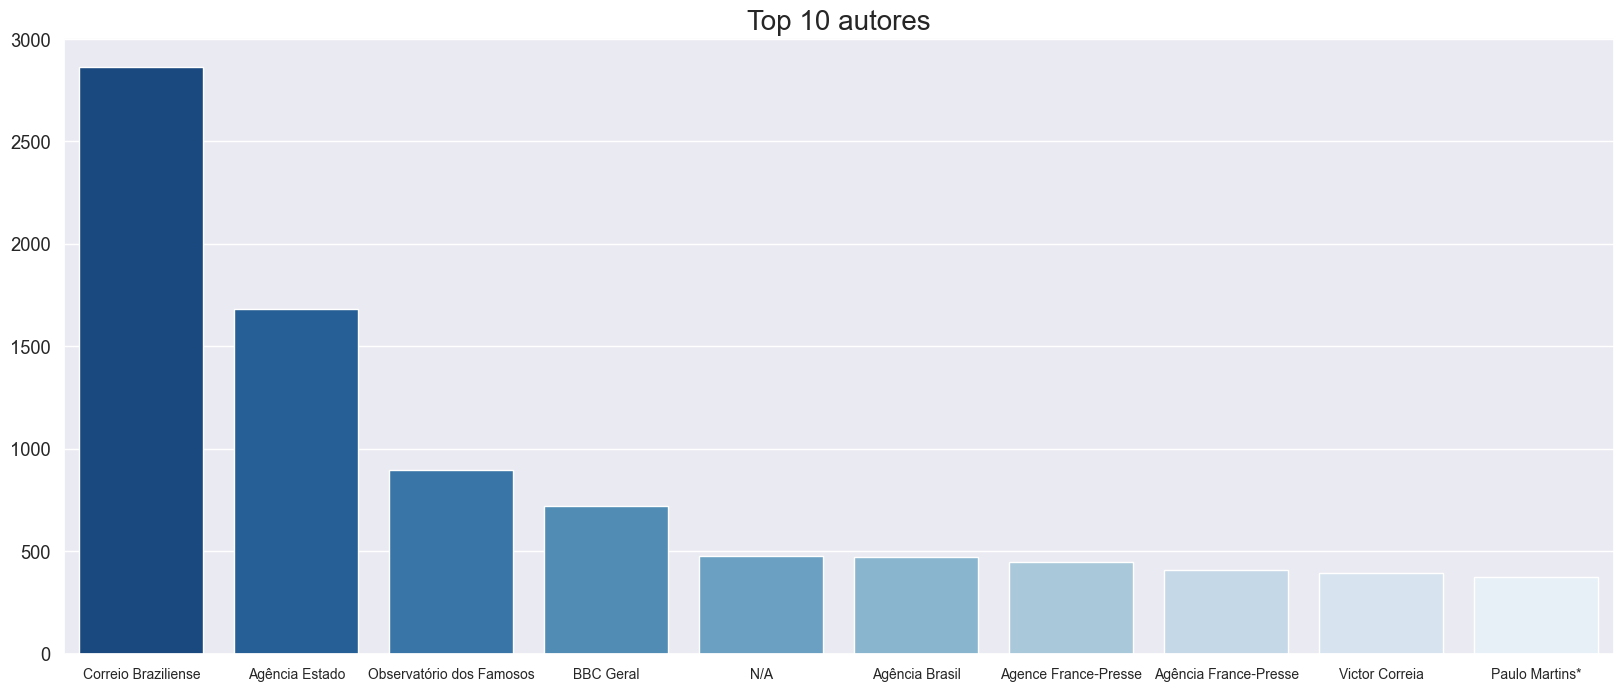

In [176]:
# Top 10 autores
#sns.set(font_scale = 1.2)
plt.figure(figsize=(20,8))
sns.barplot(data=df_qtd_autores[:10], x="autor", y="qtd", palette='Blues_r')
plt.title("Top 10 autores", size=20)
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(size=10)
plt.show()

In [156]:
# lista de stopword
stopwords.append("n")
stopwords[:20]

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele']

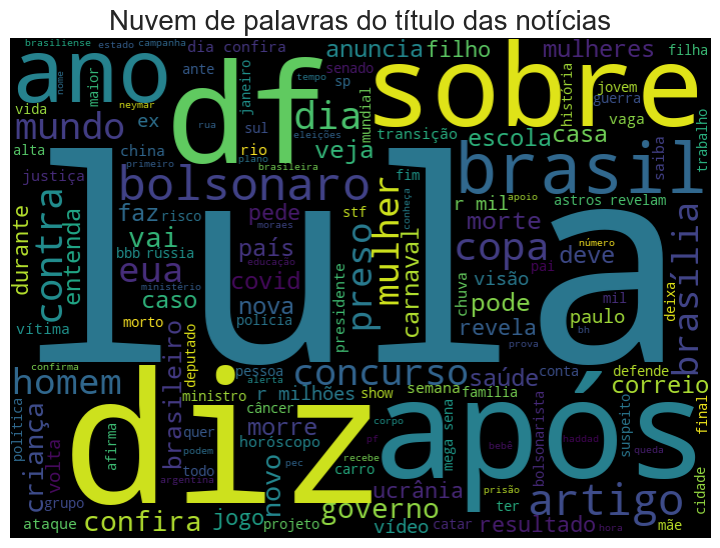

In [161]:
wordcloud = WordCloud(stopwords=stopwords, background_color = 'black', width = 700,  height = 500, max_words = 150).generate(text_titulo)

plt.figure( figsize=(12,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Nuvem de palavras do título das notícias", size=20)
plt.show()

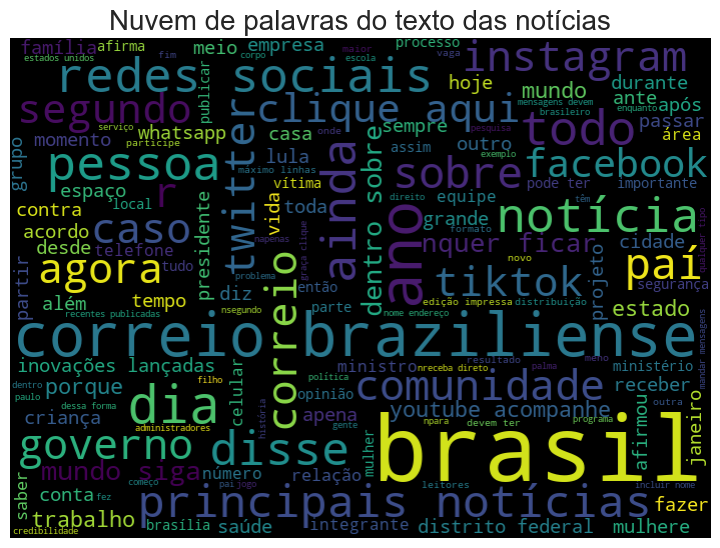

In [162]:
wordcloud = WordCloud(stopwords=stopwords, background_color = 'black', width = 700,  height = 500, max_words = 150).generate(text_texto)

plt.figure( figsize=(12,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Nuvem de palavras do texto das notícias", size=20)
plt.show()

<AxesSubplot:>

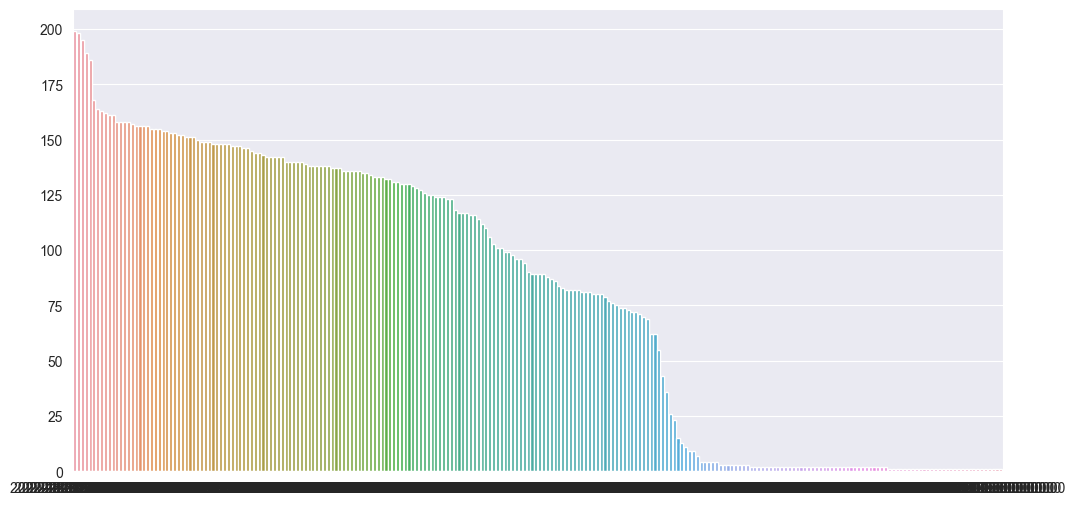

In [49]:
plt.figure(figsize=(12,6))
sns.barplot(x=df_txt['DATA_PUBLICACAO_AUX'].value_counts().index,
              y=df_txt['DATA_PUBLICACAO_AUX'].value_counts().values,
           order=df_txt['DATA_PUBLICACAO_AUX'].value_counts(ascending=False).index) #, palette=paleta_netflix)

In [ ]:
# file_name = "tb_texto_noticias"
# extensao = ".txt"

# df_txt.to_csv(path+file_name+"_tab"+"_utf8"+extensao, sep='\t', encoding='utf-8')
# df_txt.to_csv(path+file_name+extensao, sep='|', encoding='utf-8', index=False)
# df_txt.to_csv(path+file_name+"_bardup"+"_utf8"+extensao, sep=';', encoding='utf-8')

# df_txt.to_csv(path+file_name+"_tab"+"_latin1"+extensao, sep='\t', encoding ='latin1')
# df_txt.to_csv(path+file_name+extensao, sep='|', encoding ='not utf-8', index=False)
# df_txt.to_csv(path+file_name+"_bardup"+"_latin1"+extensao, sep=';', encoding ='latin1')